# Entorno

## Instalación de librerías

In [ ]:
!pip install yfinance
!pip3 install ta

## Carga de librerías

In [ ]:
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import date
from datetime import timedelta 
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from ta import add_all_ta_features
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## Opciones de display

In [ ]:
#pd.set_option('display.max_columns', 400)
#pd.set_option('display.max_rows', 12000)
#pd.set_option('display.width', 1000)
pd.set_option('use_inf_as_na', True)
pd.options.display.float_format = '{:.4f}'.format

# Parámetros

In [ ]:
dias_empieza = 9000
dias_termina = 1
ticker = 'GGAL.BA'

# Armado de la base

## Descarga y ajustes

In [ ]:
def descarga(ticker, fc_empieza, fc_termina):
  base = yf.download(ticker, start=fc_empieza, end=fc_termina)
  base['Open'] = base['Open'] * base['Adj Close'] / base['Close']
  base['Close'] = base['Close'] * base['Adj Close'] / base['Close']
  base['High'] = base['High'] * base['Adj Close'] / base['Close']
  base['Low'] = base['Low'] * base['Adj Close'] / base['Close']
  base = base[['Open', 'Close', 'High', 'Low', 'Volume']]
  base.insert(loc=0, column='Ticker', value=ticker)
  base.reset_index(level=0, inplace=True)
  base.columns=['Date', 'Ticker', 'Open', 'Close', 'High', 'Low', 'Volume']
  base = base[base.Volume > 0]
  base['vela_fl_alcista'] = np.where(base.Close > base.Open, 1, 0)
  return base

today = date.today()
fc_empieza = today + timedelta(days=(dias_empieza*-1))
fc_termina = today + timedelta(days=1)
pd.options.mode.chained_assignment = None
df = descarga(ticker, fc_empieza, fc_termina)

[*********************100%***********************]  1 of 1 completed


## Incorporación de features

### Características de la vela

In [ ]:
rango_sensibilidad = 0.01 # Cuanto más grande, más probable que tome como iguales dos velas que no lo son. Cuanto más chico, más probable que no tome como iguales dos velas que si lo son.

df.loc[:,'vela_tamaño'] = (df.High - df.Low)/df.High # El tamaño de la vela se calcula como un continuo de la diferencia entre el máximo y el mínimo, normalizado por el valor de cierre.
df.loc[:,'vela_proporcion_cuerpo'] = (abs(df.Close - df.Open))/(df.High - df.Low) # Qué tanto ocupa el cuerpo y qué tanto las mechas del total. Tamaño más grande = más cuerpo (más decisivo)
df['vela_decisiva'] = np.where((df['vela_proporcion_cuerpo'] > 0.8), df['vela_tamaño'] * df['vela_proporcion_cuerpo'], 0) # Variable cuasidummi (toma 0 cuando la vela no es decisiva, y si es decisiva toma un continuo mayor cuanto más grande es)
mitad_vela_anterior = (df.Low.shift(1) + (df.High.shift(1) - df.Low.shift(1))/2)
df.loc[:,'vela_piercing'] = np.where((df.Open < df.Close.shift(1)) & (df.Close > mitad_vela_anterior), 1, 0) # El precio abre a la baja, luego se recupera y termina por arriba de la mitad de la vela anterior. Solo válido en movimientos bajistas.
df.loc[:,'vela_dark_cloud'] = np.where((df.Open > df.Close.shift(1)) & (df.Close < mitad_vela_anterior), 1, 0) # El precio abre al alza, luego cae y termina por arriba de la mitad de la vela anterior. Solo válido en movimientos alcistas.
distancia_cuerpo_High = abs(df[["Open", "Close"]].max(axis=1) - df.High)
distancia_cuerpo_Low = abs(df[["Open", "Close"]].min(axis=1) - df.Low)
df.loc[:,'vela_early_reversal'] = (1-df['vela_proporcion_cuerpo']) * (((distancia_cuerpo_High - distancia_cuerpo_Low)/(distancia_cuerpo_High + distancia_cuerpo_Low))*(-1)) # Valores fuertes negativos son reversión bajista en tendencia alcista y alcista en tendencia bajista.

df_decisivas = df[df.vela_decisiva > 0].copy()
df_decisivas['vela_morning_star_alcista'] = np.where(((df_decisivas.vela_fl_alcista.shift(1) == 1)&(df_decisivas['vela_fl_alcista'] == 1)) & (df_decisivas.Close > (df_decisivas.Open.shift(1)+df_decisivas.Close.shift(1))/2), 1, 0) # Transición de una decisiva bajista a una alcista, que además cierra por encima de la mitad de donde cerró la decisiva anterior.
df_decisivas['vela_evening_star_bajista'] = np.where(((df_decisivas.vela_fl_alcista.shift(1) == 1)&(df_decisivas['vela_fl_alcista'] == 0)) & (df_decisivas.Close < (df_decisivas.Close.shift(1)+df_decisivas.Open.shift(1))/2), 1, 0) # Transición de una decisiva alcista a una bajista, que además cierra por encima de la mitad de donde cerró la decisiva anterior.
df_decisivas = df_decisivas[['Date', 'vela_morning_star_alcista', 'vela_evening_star_bajista']]
df = pd.merge(df, df_decisivas, how="left", on='Date')
df[['vela_morning_star_alcista', 'vela_evening_star_bajista']] = df[['vela_morning_star_alcista', 'vela_evening_star_bajista']].fillna(value=0)

df.loc[:,'vela_tweezer_bottom_alcista'] = np.where(
    (df.Close > df.Open) & (df.Close.shift(1) < df.Open.shift(1)) &
    (df.Low > df.Low.shift(1) * (1-rango_sensibilidad)) & (df.Low < df.Low.shift(1) * (1+rango_sensibilidad)) &
    (df.High > df.High.shift(1) * (1-rango_sensibilidad)) & (df.High < df.High.shift(1) * (1+rango_sensibilidad)), 
    1, 0) # Mínimo y máximo muy parecido a ayer, pero la de hoy es alcista y la de ayer bajista.

df.loc[:,'vela_tweezer_top_bajista'] = np.where(
    (df.Close < df.Open) & (df.Close.shift(1) > df.Open.shift(1)) &
    (df.Low > df.Low.shift(1) * (1-rango_sensibilidad)) & (df.Low < df.Low.shift(1) * (1+rango_sensibilidad)) &
    (df.High > df.High.shift(1) * (1-rango_sensibilidad)) & (df.High < df.High.shift(1) * (1+rango_sensibilidad)), 
    1, 0) # Mínimo y máximo muy parecido a ayer, pero la de hoy es bajista y la de ayer alcista.

df.loc[:,'vela_ying_yang_alcista'] = np.where(
    (df.Close > df.Open) & (df.Close.shift(1) < df.Open.shift(1)) &
    (df.Close > df.Close.shift(1) * (1-rango_sensibilidad)) & (df.Close < df.Close.shift(1) * (1+rango_sensibilidad)) &
    (df.Open > df.Open.shift(1) * (1-rango_sensibilidad)) & (df.Open < df.Open.shift(1) * (1+rango_sensibilidad)), 
    1, 0) # Dos velas de igual apertura y cierre, hoy cerró arriba de lo que abrió y ayer cerró abajo de lo que abrió.

df.loc[:,'vela_ying_yang_bajista'] = np.where(
    (df.Close < df.Open) & (df.Close.shift(1) > df.Open.shift(1)) &
    (df.Close > df.Close.shift(1) * (1-rango_sensibilidad)) & (df.Close < df.Close.shift(1) * (1+rango_sensibilidad)) &
    (df.Open > df.Open.shift(1) * (1-rango_sensibilidad)) & (df.Open < df.Open.shift(1) * (1+rango_sensibilidad)), 
    1, 0)

### Análisis técnico (Momentum, Volume, Volatility, Trend, Others) ver en https://technical-analysis-library-in-python.readthedocs.io/en/latest/)

In [ ]:
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

/usr/local/lib/python3.8/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


### Soportes y resistencias

In [ ]:
numero_lags = 5
rango_quiebre = 0.03

def save_data(dataset, df_all):
    df_all = pd.concat([dataset, df_all], axis=0)
    return df_all

def recorrido_soportes_resistencias(dataset, fecha_empieza_vigencia, valor_soporte, rango_quebrado, df_all, prueba_nro, Logging, clase):
  dataset = dataset[dataset.Date > fecha_empieza_vigencia]
  dataset['rango_quebrado_inicia'] = valor_soporte * (1-rango_quebrado)
  dataset['valor'] = valor_soporte
  dataset['rango_quebrado_termina'] = valor_soporte * (1+rango_quebrado)
  dataset['es_zona_prueba'] = np.where((dataset['Low'] < dataset['valor']) & (dataset['High'] > dataset['valor']), 1, 0)
  if clase == 's':
    dataset['es_zona_confirmacion'] = np.where((dataset['High'] > dataset['rango_quebrado_termina']), 1, 0)
    dataset['es_zona_quiebre'] = np.where((dataset['Low'] < dataset['rango_quebrado_inicia']), 1, 0)
  elif clase == 'r':
    dataset['es_zona_quiebre'] = np.where((dataset['High'] > dataset['rango_quebrado_termina']), 1, 0)
    dataset['es_zona_confirmacion'] = np.where((dataset['Low'] < dataset['rango_quebrado_inicia']), 1, 0)
  mascara_probado = (dataset.es_zona_prueba == 1)
  mascara_quebrado = (dataset.es_zona_quiebre == 1)
  if len(dataset[mascara_probado]) == 0 & len(dataset[mascara_quebrado]) == 0:
    resolucion = 'vigente'
    fecha_prueba = np.nan
    fecha_resolucion = np.nan
    print('La prueba número ', prueba_nro, 'nunca se realizó en la historia') if Logging else None
  elif len(dataset[mascara_probado]) == 0:
    resolucion = 'quebrado sin probarse nunca'
    fecha_prueba = np.nan
    fecha_resolucion = np.nan
    print('La prueba', prueba_nro, 'nunca se realizó, pero el valor fue quebrado') if Logging else None
  else:
    fecha_prueba = dataset[mascara_probado].iloc[0].Date
    resolucion = ''
    if len(dataset[mascara_quebrado]) > 0:
      fecha_quiebre = dataset[mascara_quebrado].iloc[0].Date
      if fecha_quiebre < fecha_prueba:      
        resolucion = 'quebrado'
        fecha_prueba = np.nan
        fecha_resolucion = fecha_quiebre
        print('La prueba', prueba_nro, 'fue quebrada antes de probarse') if Logging else None
    if resolucion != 'quebrado':
      print('La prueba número ', prueba_nro, 'empezó el día ', fecha_prueba, ' cuando el mínimo fue ', dataset[mascara_probado].iloc[0].Low, ' y el máximo fue ', dataset[mascara_probado].iloc[0].High) if Logging else None
      mascara_resuelto = ((dataset.Date > fecha_prueba)&(dataset.es_zona_confirmacion == 1))|((dataset.Date > fecha_prueba)&(dataset.es_zona_quiebre == 1))
      if len(dataset[mascara_resuelto]): # La prueba fue resuelta
        fecha_resolucion = dataset[mascara_resuelto].iloc[0].Date
        print('Fue resuelta el día ', fecha_resolucion, ' cuando el mínimo fue ', dataset[mascara_resuelto].iloc[0].Low, ' y el máximo fue ', dataset[mascara_resuelto].iloc[0].High) if Logging else None
        if (dataset[mascara_resuelto].iloc[0].es_zona_confirmacion == 1) & (dataset[mascara_resuelto].iloc[0].es_zona_quiebre == 1):
          resolucion = 'indeterminado por resolverse el mismo día'
          print('La prueba número ', prueba_nro, 'completó la historia sin ser determinada') if Logging else None
        elif dataset[mascara_resuelto].iloc[0].es_zona_confirmacion == 1:
          resolucion = 'probado'
          print('La prueba número ', prueba_nro, 'completó la historia probada el día ', fecha_resolucion) if Logging else None
        elif dataset[mascara_resuelto].iloc[0].es_zona_quiebre == 1:
          resolucion = 'quebrado'
          print('La prueba número ', prueba_nro, 'completó la historia quebrada el día ', fecha_resolucion) if Logging else None
      else:
        fecha_resolucion = np.nan
        resolucion = 'indeterminado por no resolverse nunca'
        print('No llegó a resolverse en el mes.') if Logging else None
  analisis_prueba_list = []
  analisis_prueba_list.append([ticker+str(round(valor_soporte,2)), ticker, valor_soporte, fecha_empieza_vigencia, prueba_nro, fecha_prueba, fecha_resolucion, resolucion])
  analisis_prueba = pd.DataFrame(analisis_prueba_list, columns = ["id_soporte", "ticker", "valor", "fecha_ingreso_vigencia", "nro_prueba_historia", "fecha_prueba", "fecha_resolucion", "tipo_resolucion"])
  analisis_prueba['fecha_prueba'] = pd.to_datetime(analisis_prueba['fecha_prueba'])
  analisis_prueba['fecha_resolucion'] = pd.to_datetime(analisis_prueba['fecha_resolucion'])
  df_all = save_data(df_all, analisis_prueba)
  if resolucion == 'probado':
    print('La prueba número ', prueba_nro, 'admite nuevas pruebas') if Logging else None
    prueba_nro = prueba_nro + 1
    dataset = dataset[dataset.Date > fecha_resolucion]
    return recorrido_soportes_resistencias(dataset, fecha_empieza_vigencia, valor_soporte, rango_quebrado, df_all, prueba_nro, Logging, clase)
  else:
    return df_all

def calculo_historia(dataset, lags, rq, l):
  global puntos_soporte, fechas_soporte, fechas_vigencia_soporte, puntos_resistencia, fechas_resistencia, fechas_vigencia_resistencia
  i = 1
  while i < (lags+1): # Genera ventanas alrededor para analizar si es soporte
      colname = 'l%sb' % (i)                                                  
      dataset[colname] = round(dataset['Close'].shift(i),2)
      colname = 'l%sf' % (i)                                                  
      dataset[colname] = round(dataset['Close'].shift(-i),2)
      i = i + 1
  x = np.arange(len(dataset.Date))
  dataset['minb'] = round(dataset.filter(regex=("^l(.*)b$")).min(axis=1),2)
  dataset['minf'] = round(dataset.filter(regex=("^l(.*)f$")).min(axis=1),2)
  dataset['maxb'] = round(dataset.filter(regex=("^l(.*)b$")).max(axis=1),2)
  dataset['maxf'] = round(dataset.filter(regex=("^l(.*)f$")).max(axis=1),2)
  dataset['Soporte'] = np.where((dataset.index > lags) & (dataset['Close']<dataset['minb']) & (dataset['Close']<dataset['minf']), 1, 0)
  dataset['Soporte'] = np.where((dataset.index > (dataset.shape[0] - lags)), 0 , dataset.Soporte * dataset['Close'])
  dataset['Resistencia'] = np.where((dataset.index > lags) & (dataset['Close']>dataset['maxb']) & (dataset['Close']>dataset['maxf']), 1, 0)
  dataset['Resistencia'] = np.where((dataset.index > (dataset.shape[0] - lags)), 0 , dataset.Resistencia * dataset['Close'])
  dataset = dataset[['Date', 'Ticker', 'Close', 'Low', 'High', 'Soporte', 'Resistencia']]
  dataset['Date_vigencia'] = dataset.Date.shift(-lags)
  dataset.replace(0, np.nan, inplace=True)
  puntos_soporte = dataset[dataset.Soporte > 0]['Soporte'].to_numpy() # Lista de soportes
  fechas_soporte = dataset[dataset.Soporte > 0]['Date'].to_numpy() # Lista de fechas de soporte
  fechas_vigencia_soporte = dataset[dataset.Soporte > 0]['Date_vigencia'].to_numpy() # Lista de fechas de soporte
  print('EMPIEZA ANÁLISIS DE SOPORTES') if l else None
  dataset_all_soportes = pd.DataFrame()
  i = 0
  while i < len(puntos_soporte):  # Recorre la lista de soportes
    dataset_all_soportes = recorrido_soportes_resistencias(dataset, fechas_vigencia_soporte[i], puntos_soporte[i], rq, dataset_all_soportes, 1, Logging=l, clase='s')
    i = i + 1
  print('EMPIEZA ANÁLISIS DE RESISTENCIAS') if l else None
  puntos_resistencia = dataset[dataset.Resistencia > 0]['Resistencia'].to_numpy() # Lista de resistencia
  fechas_resistencia = dataset[dataset.Resistencia > 0]['Date'].to_numpy() # Lista de fechas de resistencia
  fechas_vigencia_resistencia = dataset[dataset.Resistencia > 0]['Date_vigencia'].to_numpy() # Lista de fechas de soporte
  dataset_all_resistencias = pd.DataFrame()
  i = 0
  while i < len(puntos_resistencia):  # Recorre la lista de resistencia
    print('ANALIZO EL PUNTO ', puntos_resistencia[i], ' DEL ', fechas_resistencia[i], ' QUE ENTRARÍA EN VIGENCIA EL ', fechas_vigencia_resistencia[i]) if l else None
    dataset_all_resistencias = recorrido_soportes_resistencias(dataset, fechas_vigencia_resistencia[i], puntos_resistencia[i], rq, dataset_all_resistencias, 1, Logging=l, clase='r')
    i = i + 1
  return dataset_all_soportes, dataset_all_resistencias

def seleccion_linea(dataset, fecha, precio, clase):
  mascara_iniciados_antes = (dataset.fecha_ingreso_vigencia < fecha)
  mascara_vigentes_hoy = (dataset.tipo_resolucion == 'vigente')
  mascara_quebrados_despues = ((dataset.tipo_resolucion == 'quebrado') & (dataset.fecha_resolucion > fecha))|((dataset.tipo_resolucion == 'indeterminado por resolverse el mismo día') & (dataset.fecha_resolucion > fecha))
  vigentes = dataset[mascara_iniciados_antes & (mascara_vigentes_hoy|mascara_quebrados_despues)].sort_values(by=['fecha_ingreso_vigencia'])
  if clase == 's':
    try:
      valor = vigentes.iloc[vigentes['valor'].argmax()].valor
      pruebas = vigentes.iloc[vigentes['valor'].argmax()].nro_prueba_historia
      antiguedad = (fecha - (vigentes.iloc[vigentes['valor'].argmax()].fecha_ingreso_vigencia)).days
      return valor, pruebas, antiguedad
    except:
      return np.nan, np.nan, np.nan
  elif clase == 'r':
    try:
      valor = vigentes.iloc[vigentes['valor'].argmin()].valor
      pruebas = vigentes.iloc[vigentes['valor'].argmin()].nro_prueba_historia
      antiguedad = (fecha - (vigentes.iloc[vigentes['valor'].argmin()].fecha_ingreso_vigencia)).days
      return valor, pruebas, antiguedad
    except:
      return np.nan, np.nan, np.nan

datasets_soportes_resistencias = {}

periodos_sr = [5, 10, 20]
for num_lags in periodos_sr:
  df_soportes, df_resistencias = calculo_historia(df, num_lags, rango_quiebre, l=False)
  df = df[df.columns.drop(list(df.filter(regex='l.*b|l.*f|minb|minf|maxb|maxf|Soporte|Resistencia')))]
  
  lista_soportes_diarios = [seleccion_linea(df_soportes, f, p, 's') for f, p in zip(df['Date'], df['Close'])]
  df['soporte_%s_valor' % (num_lags)] = [a_tuple[0] for a_tuple in lista_soportes_diarios]
  df['soporte_%s_numero_pruebas' % (num_lags)] = [a_tuple[1] for a_tuple in lista_soportes_diarios]
  df['soporte_%s_dias_antiguedad' % (num_lags)] = [a_tuple[2] for a_tuple in lista_soportes_diarios]

  lista_resistencias_diarias  = [seleccion_linea(df_resistencias, f, p, 'r') for f, p in zip(df['Date'], df['Close'])]
  df['resistencia_%s_valor' % (num_lags)] = [a_tuple[0] for a_tuple in lista_resistencias_diarias]
  df['resistencia_%s_numero_pruebas' % (num_lags)] = [a_tuple[1] for a_tuple in lista_resistencias_diarias]
  df['resistencia_%s_dias_antiguedad' % (num_lags)] = [a_tuple[2] for a_tuple in lista_resistencias_diarias]
  datasets_soportes_resistencias["df_soportes_{0}".format(num_lags)] = df_soportes
  datasets_soportes_resistencias["df_resistencias_{0}".format(num_lags)] = df_resistencias

df = df[df.columns.drop(list(df.filter(regex='l(.*)b')))]
df = df[df.columns.drop(list(df.filter(regex='l(.*)f')))]
df = df[df.columns.drop(list(df.filter(regex='maxf|maxb|minf|minb')))]

for num_lags in periodos_sr:
  df['chart_dist_a_resistencia_%s' % (num_lags)] = df['resistencia_%s_valor' % (num_lags)]/df['Close']
  df['chart_dist_a_soporte_%s' % (num_lags)] = df['soporte_%s_valor' % (num_lags)]/df['Close']

df = df.loc[:,~df.columns.str.startswith('soporte')].copy()
df = df.loc[:,~df.columns.str.startswith('resistencia')].copy()

<ipython-input-55-2c7ce26755f9>:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[colname] = round(dataset['Close'].shift(i),2)
<ipython-input-55-2c7ce26755f9>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[colname] = round(dataset['Close'].shift(-i),2)


# Dataset

In [ ]:
for col in df.columns[7:]:
  try:
    if col == 'Close':
      pass
    elif pearsonr(df[col], df['Close'])[0] > 0.975:
      print('La correlación de ', col, 'con el precio es alta, por lo que normalizo la columna', col)
      df[col] = df[col]/df['Close']
  except:
    pass
df = df.iloc[200:, :].reset_index(drop=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

La correlación de  volume_vwap con el precio es alta, por lo que normalizo la columna volume_vwap
La correlación de  volatility_kcc con el precio es alta, por lo que normalizo la columna volatility_kcc
La correlación de  volatility_kch con el precio es alta, por lo que normalizo la columna volatility_kch
La correlación de  volatility_kcl con el precio es alta, por lo que normalizo la columna volatility_kcl
La correlación de  volatility_dcl con el precio es alta, por lo que normalizo la columna volatility_dcl
La correlación de  volatility_dch con el precio es alta, por lo que normalizo la columna volatility_dch
La correlación de  volatility_dcm con el precio es alta, por lo que normalizo la columna volatility_dcm
La correlación de  trend_sma_fast con el precio es alta, por lo que normalizo la columna trend_sma_fast
La correlación de  trend_sma_slow con el precio es alta, por lo que normalizo la columna trend_sma_slow
La correlación de  trend_ema_fast con el precio es alta, por lo que no

# Modelo

#### Primer análisis explicativo

Buscamos responder:

*   Entre target 1, target 7, target 15, target 30, ¿hay diferencia en performance?
*   ¿Entre modelo que predice variación y modelo que predice variación absoluta, hay diferencias?
*   ¿Entre estandarizar y no, hay diferencia en performance?
*   Entre regresión simple, regresión Lasso (75%, 50%, 25% de las variables), ¿hay diferencia en performance?
*   ¿Qué coeficientes da? ¿Qué coeficientes se mantienen cuando se regulariza?


In [ ]:
results = pd.DataFrame(columns = ['dias_target', 'media_target', 'mediana_target', 'tipo_target', 'alpha', 'nu_variables', 'MAE_train', 'MAE_oos'])
for target in [1, 3, 5, 7, 10, 14, 21, 30]:
  df['target'] = df.Close.shift(-target)/df.Close - 1
  df = df.iloc[0:-target,:]
  oos_last = df.tail(500).copy()
  oos_last['oos'] = 'last_200'
  oos_random = df[df.Date.isin(df.sample(500)['Date'])].copy()
  oos_random['oos'] = 'random'
  oos = pd.concat([oos_last, oos_random]).sort_values(by='Date').drop_duplicates(subset=['Date'], keep='first').reset_index(drop=True)
  df_dev = df[~df.Date.isin(oos.Date)].copy()
  for absolute in [True, False]:
    if absolute:
      tipo_target = 'Variación porcenutal en valor absoluto'
      df_dev['target'] = abs(df_dev['target'])
      oos['target'] = abs(oos['target'])
      X_train = df_dev[[col for col in df_dev.iloc[:, 7:-1] if col.startswith('v') is True]]
      y_train = df_dev['target']
      X_oos = oos[[col for col in oos.iloc[:, 7:-1] if col.startswith('v') is True]]
      y_oos = oos['target']
    else:
      tipo_target = 'Variación porcentual'
      df_dev['target'] = df_dev['target']
      oos['target'] = oos['target']
      X_train = df_dev[[col for col in df_dev.iloc[:, 7:-1] if col.startswith('v') is False]]
      y_train = df_dev['target']
      X_oos = oos[[col for col in oos.iloc[:, 7:-2] if col.startswith('v') is False]]
      y_oos = oos['target']
    X_train = X_train.fillna(X_train.median())
    X_oos = X_oos.fillna(X_oos.median())
    for exp in range(-5, 3):
      alpha = 10 ** exp
      regr = Lasso(alpha=alpha).fit(X_train, y_train)
      mae_train = mean_absolute_error(regr.predict(X_train), y_train)
      mae_oos = mean_absolute_error(regr.predict(X_oos), y_oos)
      results.loc[len(results)] = [target, abs(y_oos).mean(), abs(y_oos).median(), tipo_target, alpha, np.count_nonzero(regr.coef_), mae_train, mae_oos]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e+00, tolerance: 4.322e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e-03, tolerance: 4.322e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-03, tolerance: 4.322e-04

#### Modelos reentrenados en ventanas

In [ ]:
'''

duracion_train = 1000
duracion_test = 500

s_tr = 0
e_tr = duracion_train
s_te = duracion_train
e_te = duracion_train + duracion_test
full_y_test = df.iloc[s_te:len(df), -1].astype('float64')
full_y_pred_rl = np.array([])
full_y_pred_rf = np.array([])
full_y_pred_knn = np.array([])
correlations_target = pd.DataFrame(columns=['variable', 'correlacion', 'algoritmo'])

while e_te <= len(df):
  print('Empieza ciclo de entrenamiento entre índices', s_tr, 'y', e_tr - 1, 'y testeo entre índices', s_te, 'y', e_te)
  X_train = df.iloc[s_tr:e_tr, 7:-1].astype('float64')
  y_train = df.iloc[s_tr:e_tr:, -1].astype('float64')
  X_test = df.iloc[s_te:e_te, 7:-1]
  y_test = df.iloc[s_te:e_te, -1]

  # Regresión
  print(' Start ajuste Regresión LASSO')
  param_dict_rl = {
      #"pca__n_components":['mle', 5, 20],
      "lasso__alpha":[0.001, 0.01, 0.1, 1.5, 4]
      }
  pipe_rl = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='median')),
      ('scale', MinMaxScaler()),
      #('pca', PCA()),
      ('lasso', Lasso())
  ])

  estimator_rl = GridSearchCV(pipe_rl, param_dict_rl, verbose=0).fit(X_train, y_train)
  y_pred_rl = estimator_rl.predict(X_test)
  full_y_pred_rl = np.append(full_y_pred_rl, y_pred_rl)
  for col in X_test.columns:
    try:
      correlations_target.loc[len(correlations_target)] = [col, pearsonr(X_test[col], y_pred_rl)[0], 'Regresión Lasso']
    except:
      pass

  # KNN
  print(' Start ajuste KNN')
  param_dict_knn = {
      #"pca__n_components":['mle', 5, 20],
      "knn__n_neighbors":[2, 5, 8, 12, 20]
      }
  pipe_knn = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='median')),
      ('scale', MinMaxScaler()),
      #('pca', PCA()),
      ('knn', KNeighborsRegressor())
  ])

  estimator_knn = GridSearchCV(pipe_knn, param_dict_knn, verbose=0).fit(X_train, y_train)
  y_pred_knn = estimator_knn.predict(X_test)
  full_y_pred_knn = np.append(full_y_pred_knn, y_pred_knn)
  for col in X_test.columns:
    try:
      correlations_target.loc[len(correlations_target)] = [col, pearsonr(X_test[col], y_pred_knn)[0], 'KNN']
    except:
      pass

  # Random forest
  print(' Start ajuste Random Forest')
  param_dict_rf = {
      #"pca__n_components":['mle', 5, 20],
      "forest__n_estimators":[5, 20, 40]
      }
  pipe_rf = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='median')),
      ('scale', MinMaxScaler()),
      #('pca', PCA()),
      ('forest', RandomForestRegressor())
  ])

  estimator_rf = GridSearchCV(pipe_rf, param_dict_rf, verbose=0).fit(X_train, y_train)
  y_pred_rf = estimator_rf.predict(X_test)
  full_y_pred_rf = np.append(full_y_pred_rf, y_pred_rf)
  for col in X_test.columns:
    try:
      correlations_target.loc[len(correlations_target)] = [col, pearsonr(X_test[col], y_pred_rf)[0], 'Random Forest']
    except:
      pass

  #print('Appendie y ahora la longitud de full_y_pred es de', len(full_y_pred))
  e_tr = e_te
  s_tr = e_tr - duracion_train
  s_te = e_te

  if e_te == len(df):
    print('Fin!')
    break
  else:
    e_te = e_te + duracion_test

  if e_te > len(df):
    e_te = len(df)
  else:
    pass

import seaborn as sns
sns.set(rc={'figure.figsize':(181.7,31.27)})
sns.boxplot(x='variable', y='correlacion', data=correlations_target, hue="algoritmo")

testeo = pd.DataFrame({'test':np.array(full_y_test), 
                       'pred_rf':full_y_pred_rf,
                       'pred_rl':full_y_pred_rl,
                       'pred_knn':full_y_pred_knn
                       })

testeo['rango_min'] = -0.15 # testeo[['pred_rf','pred_rl','pred_knn']].max(axis=1) * (-1) - testeo[['pred_rf','pred_rl','pred_knn']].std(axis=1)
testeo['rango_max'] = 0.15 # testeo[['pred_rf','pred_rl','pred_knn']].max(axis=1) + testeo[['pred_rf','pred_rl','pred_knn']].std(axis=1)
testeo['entre_ambas'] = np.where((testeo['test'] < testeo['rango_max'])&(testeo['test'] > testeo['rango_min']), 1, 0)
print('Rango promedio:', round((testeo['rango_max'] - testeo['rango_min']).mean(),2))
print('Porcentaje de aciertos:', round(testeo.entre_ambas.mean(),2))
'''

'\n\nduracion_train = 1000\nduracion_test = 500\n\ns_tr = 0\ne_tr = duracion_train\ns_te = duracion_train\ne_te = duracion_train + duracion_test\nfull_y_test = df.iloc[s_te:len(df), -1].astype(\'float64\')\nfull_y_pred_rl = np.array([])\nfull_y_pred_rf = np.array([])\nfull_y_pred_knn = np.array([])\ncorrelations_target = pd.DataFrame(columns=[\'variable\', \'correlacion\', \'algoritmo\'])\n\nwhile e_te <= len(df):\n  print(\'Empieza ciclo de entrenamiento entre índices\', s_tr, \'y\', e_tr - 1, \'y testeo entre índices\', s_te, \'y\', e_te)\n  X_train = df.iloc[s_tr:e_tr, 7:-1].astype(\'float64\')\n  y_train = df.iloc[s_tr:e_tr:, -1].astype(\'float64\')\n  X_test = df.iloc[s_te:e_te, 7:-1]\n  y_test = df.iloc[s_te:e_te, -1]\n\n  # Regresión\n  print(\' Start ajuste Regresión LASSO\')\n  param_dict_rl = {\n      #"pca__n_components":[\'mle\', 5, 20],\n      "lasso__alpha":[0.001, 0.01, 0.1, 1.5, 4]\n      }\n  pipe_rl = Pipeline(steps=[\n      (\'impute\', SimpleImputer(strategy=\'media

#### Un solo modelo: Comparación de modelos

In [ ]:
models = [LinearRegression(),
          XGBRegressor(),
          KernelRidge(),
          ElasticNet(),
          BayesianRidge(),
          GradientBoostingRegressor(),
          SVR()
          ]

for model in models:
  df['target'] = df.Close.shift(-7)/df.Close - 1
  df = df.iloc[0:-7,:]
  oos = df[df.Date.isin(df.sample(400)['Date'])].copy()
  oos['oos'] = 'random'
  df_dev = df[~df.Date.isin(oos.Date)].copy()

  # Modelo de variación porcentual
  X_train = df_dev[[col for col in df_dev.iloc[:, 7:-1] if col.startswith('v') is False]]
  y_train = df_dev['target']
  X_oos = oos[[col for col in oos.iloc[:, 7:-2] if col.startswith('v') is False]]
  y_oos = oos['target']
  X_train = X_train.fillna(X_train.median())
  X_oos = X_oos.fillna(X_oos.median())
  regr = model.fit(X_train, y_train)
  oos['prediction_porcentual'] = regr.predict(X_oos)

  # Modelo de variación absoluta
  X_train = df_dev[[col for col in df_dev.iloc[:, 7:-1] if col.startswith('v') is True]]
  y_train = abs(df_dev['target'])
  X_oos = oos[[col for col in oos.iloc[:, 7:-1] if col.startswith('v') is True]]
  y_oos = abs(oos['target'])
  X_train = X_train.fillna(X_train.median())
  X_oos = X_oos.fillna(X_oos.median())
  regr = model.fit(X_train, y_train)

  oos['target_abs'] = abs(oos['target'])
  oos['prediction_absolute'] = regr.predict(X_oos)
  oos['rango_min'] = oos['prediction_porcentual'] - oos['prediction_absolute'] * 1.25
  oos['rango_max'] = oos['prediction_porcentual'] + oos['prediction_absolute'] * 1.25
  oos['rango_total'] = oos['rango_max'] - oos['rango_min']
  rango_tipico = oos['rango_total'].mean()/2

  aciertos = round(np.where((oos['target'] > oos['rango_min'])&(oos['target'] < oos['rango_max']), 1, 0).mean(), 2)
  aciertos_naive = round(np.where((oos['target'] > -rango_tipico)&(oos['target'] < rango_tipico), 1, 0).mean(), 2)
  print('Usando el modelo', model, 'Los aciertos fueron ', aciertos, '. Si en cambio se hubiera asignado invariablemente a todas las observaciones el mismo rango,', round(rango_tipico, 3), 'los aciertos hubieran sido ', aciertos_naive)

Usando el modelo LinearRegression() Los aciertos fueron  0.7 . Si en cambio se hubiera asignado invariablemente a todas las observaciones el mismo rango, 0.09 los aciertos hubieran sido  0.72
[19:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Usando el modelo XGBRegressor() Los aciertos fueron  0.79 . Si en cambio se hubiera asignado invariablemente a todas las observaciones el mismo rango, 0.085 los aciertos hubieran sido  0.78


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Usando el modelo KernelRidge() Los aciertos fueron  0.68 . Si en cambio se hubiera asignado invariablemente a todas las observaciones el mismo rango, 0.078 los aciertos hubieran sido  0.7
Usando el modelo ElasticNet() Los aciertos fueron  0.72 . Si en cambio se hubiera asignado invariablemente a todas las observaciones el mismo rango, 0.088 los aciertos hubieran sido  0.71
Usando el modelo BayesianRidge() Los aciertos fueron  0.7 . Si en cambio se hubiera asignado invariablemente a todas las observaciones el mismo rango, 0.089 los aciertos hubieran sido  0.72
Usando el modelo GradientBoostingRegressor() Los aciertos fueron  0.76 . Si en cambio se hubiera asignado invariablemente a todas las observaciones el mismo rango, 0.088 los aciertos hubieran sido  0.73
Usando el modelo SVR() Los aciertos fueron  0.89 . Si en cambio se hubiera asignado invariablemente a todas las observaciones el mismo rango, 0.132 los aciertos hubieran sido  0.86


#### Un solo modelo: SVR

In [ ]:
df['target'] = df.Close.shift(-7)/df.Close - 1
X_train_pc = df_dev[[col for col in df_dev.iloc[:, 7:-1] if col.startswith('v') is False]]
y_train_pc = df_dev['target']
X_train_abs = df_dev[[col for col in df_dev.iloc[:, 7:-1] if col.startswith('v') is True]]
y_train_abs = abs(df_dev['target'])

param_dict_svr = {
    "impute__strategy":['mean', 'median', 'most_frequent'],
    "pca__n_components":['None', 5, 20, 'mle'],
    "svr__gamma":['scale', 'auto'],
    "svr__C":[0.01, 0.1, 0.5, 1, 1.5, 5]
    }

pipe_svr = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler()),
    ('pca', PCA()),
    ('svr', SVR())
])

estimator_svr_pc = GridSearchCV(pipe_svr, param_dict_svr, verbose=0).fit(X_train_pc, y_train_pc)
estimator_svr_abs = GridSearchCV(pipe_svr, param_dict_svr, verbose=0).fit(X_train_abs, y_train_abs)
oos['prediction_porcentual'] = estimator_svr_pc.predict(oos[[col for col in oos.iloc[:, 7:list(oos.columns).index('chart_dist_a_soporte_20')+1] if col.startswith('v') is False]])
oos['target_abs'] = abs(oos['target'])
oos['prediction_absolute'] = estimator_svr_abs.predict(oos[[col for col in oos.iloc[:, 7:list(oos.columns).index('chart_dist_a_soporte_20')+1] if col.startswith('v') is True]])
oos['rango_min'] = oos['prediction_porcentual'] - oos['prediction_absolute'] * 1.5
oos['rango_max'] = oos['prediction_porcentual'] + oos['prediction_absolute'] * 1.5
oos['rango_total'] = oos['rango_max'] - oos['rango_min']
rango_tipico = oos['rango_total'].mean()/2
aciertos = round(np.where((oos['target'] > oos['rango_min'])&(oos['target'] < oos['rango_max']), 1, 0).mean(), 2)
aciertos_naive = round(np.where((oos['target'] > -rango_tipico)&(oos['target'] < rango_tipico), 1, 0).mean(), 2)
print('Usando el modelo', model, 'Los aciertos fueron ', aciertos, '. Si en cambio se hubiera asignado invariablemente a todas las observaciones el mismo rango,', round(rango_tipico, 3), 'los aciertos hubieran sido ', aciertos_naive)

### Predicción

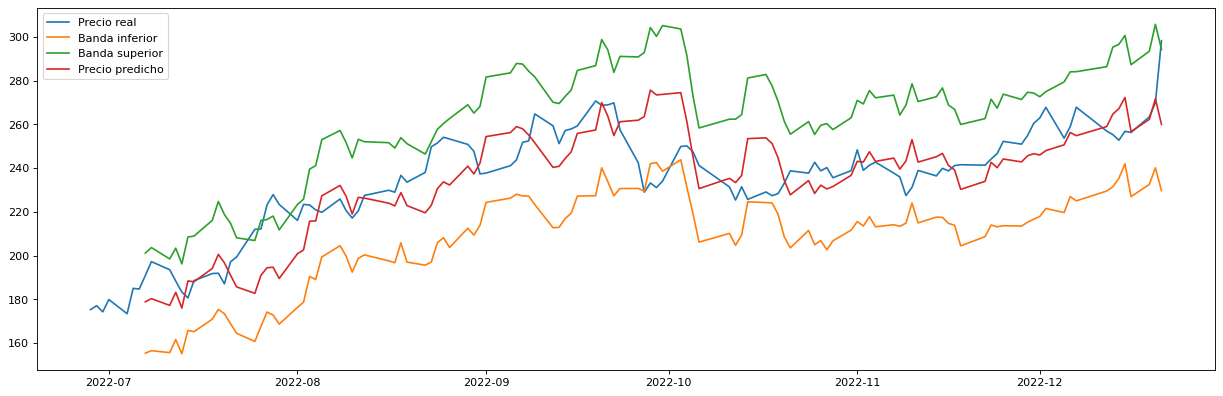

In [ ]:
last_20 = df.tail(120).reset_index(drop=True)
last_20['prediction_porcentual'] = estimator_svr_pc.predict(last_20[[col for col in last_20.iloc[:, 7:list(last_20.columns).index('chart_dist_a_soporte_20')+1] if col.startswith('v') is False]])
last_20['prediction_absolute'] = estimator_svr_abs.predict(last_20[[col for col in last_20.iloc[:, 7:list(last_20.columns).index('chart_dist_a_soporte_20')+1] if col.startswith('v') is True]])
last_20['prediction_min'] = last_20['prediction_porcentual'] - last_20['prediction_absolute'] * 1.1
last_20['prediction_max'] = last_20['prediction_porcentual'] + last_20['prediction_absolute'] * 1.1
last_20['plot_price'] = last_20.Close
last_20['plot_price_predicho'] = last_20.Close.shift(7) * (1 + last_20.prediction_porcentual.shift(7))
last_20['plot_price_min'] = last_20.Close.shift(7) * (1 + last_20.prediction_min)
last_20['plot_price_max'] = last_20.Close.shift(7) * (1 + last_20.prediction_max)
#last_20 = last_20[['Date', 'plot_price', 'plot_price_predicho', 'plot_price_min', 'plot_price_max']].dropna()
figure(figsize=(19, 6), dpi=80)
plt.plot(last_20['Date'], last_20['plot_price'], label = "Precio real")
plt.plot(last_20['Date'], last_20['plot_price_min'], label = "Banda inferior")
plt.plot(last_20['Date'], last_20['plot_price_max'], label = "Banda superior")
plt.plot(last_20['Date'], last_20['plot_price_predicho'], label = "Precio predicho")
plt.legend()
plt.show()


In [ ]:
pred = round(last_20.tail(1)['Close'].values[0] * (1 + last_20.tail(1)['prediction_porcentual'].values[0]), 2)
min = round(last_20.tail(1)['Close'].values[0] * (1 - last_20.tail(1)['prediction_absolute'].values[0]), 2)
max = round(last_20.tail(1)['Close'].values[0] * (1 + last_20.tail(1)['prediction_absolute'].values[0]), 2)
print('El precio predicho para las próximas 7 ruedas es de', pred, 'con un mínimo predicho de', min, 'y un máximo predicho de', max)

El precio predicho para las próximas 7 ruedas es de 304.2 con un mínimo predicho de 264.27 y un máximo predicho de 332.43
